In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import tqdm

In [2]:
SATELLITE_ZARR_PATH = "/home/ben/eumetsat_seviri_hrv_uk.zarr"

dataset = xr.open_dataset(
    SATELLITE_ZARR_PATH, 
    engine="zarr",
    chunks="auto",  # Load the data as a Dask array
)

print(dataset)

<xarray.Dataset>
Dimensions:  (time: 173624, y: 891, x: 1843)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Data variables:
    data     (time, y, x) int16 dask.array<chunksize=(22, 891, 1843), meta=np.ndarray>


In [3]:
data_array = dataset['data']

In [4]:
frame = data_array.sel(
        time="2021-06-01 16:50"
        )
    
frame.shape

(891, 1843)

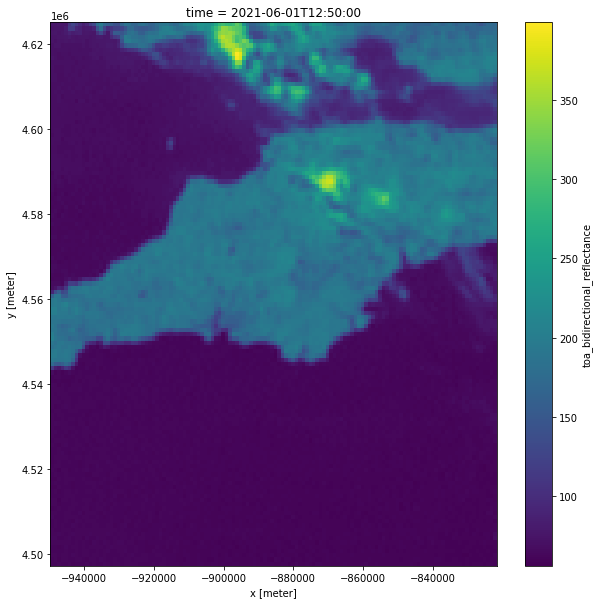

In [20]:
from datetime import datetime

def crop_two_by_one(x,y,size):

    subset = (
        data_array
        # Select a time slice using 'sel' (short for 'select').
        .sel(
            time="2021-06-01 12:50"
            )
        
        # Select a spatial slice using the array indices. 'isel' is short for 'index select'.
        # We could use isel instead of sel to select the date range, if we wanted to select the
        # time range using indices instead of datetime labels.
        .isel(
            x=slice(x,x+size),
            y=slice(y,y+size),
        )
    )

    subset.plot(figsize=(10,10))

crop_two_by_one(850, 300, 128)

In [21]:
def get_day_slice(date):
    data_slice = data_array.loc[
        {
            # 10am to 4pm
            "time": slice(
                date + datetime.timedelta(hours=6),
                date + datetime.timedelta(hours=20),
            )
        }
    ].isel(
        x=slice(850, 850+128),
        y=slice(300, 300+128),
    )
    
    # sometimes there is no data
    if len(data_slice.time) == 0:
        return None
    return data_slice

In [27]:
import datetime
from datetime import timedelta

start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2020, 3, 30)

cur = start_date
days_to_get = []
while cur != end_date + datetime.timedelta(days=1):
    days_to_get.append(cur)
    cur = cur + datetime.timedelta(days=1)

print(len(days_to_get))
get_day_slice(days_to_get[1])

90


<xarray.DataArray 'data' (time: 169, y: 128, x: 128)>
dask.array<getitem, shape=(169, 128, 128), dtype=int16, chunksize=(22, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-02T06:00:00 ... 2020-01-02T20:00:00
  * x        (x) float32 -8.221e+05 -8.231e+05 ... -9.481e+05 -9.491e+05
    x_osgb   (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
  * y        (y) float32 4.498e+06 4.499e+06 4.5e+06 ... 4.624e+06 4.625e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
Attributes:
    _satpy_id:                              !!python/object/apply:satpy.datas...
    ancillary_variables:                    []
    area:                                   msg_seviri_rss_1km:\n  descriptio...
    calibration:                            reflectance
    coordinates:                            acq_time
    georef_offset_corrected:                True
    modifiers:                              []
    name:                                   HRV
    orbital_parameters:                     projection_altitude: 35785831.0\n...
    platform_name:                          Meteosat-10
    reader:                                 seviri_l1b_native
    resolution:                             1000.134348869
    sensor:                                 seviri
    standard_name:                          toa_bidirectional_reflectance
    sun_earth_distance_correction_applied:  True
    sun_earth_distance_correction_factor:   1.0282367454433767
    wavelength:                             [0.5, 0.7, 0.9, 'µm']

In [28]:

slices = []
for date in tqdm.tqdm(days_to_get):
    slc = get_day_slice(date)
    if slc is None:
        continue
    slices.append(slc)

100%|██████████| 90/90 [00:00<00:00, 364.56it/s]


In [29]:
combined_sat_slices = xr.concat(slices, dim='time')

In [30]:
combined_sat_slices

<xarray.DataArray 'data' (time: 10343, y: 128, x: 128)>
dask.array<concatenate, shape=(10343, 128, 128), dtype=int16, chunksize=(22, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T06:00:00 ... 2020-03-30T20:00:00
  * x        (x) float32 -8.221e+05 -8.231e+05 ... -9.481e+05 -9.491e+05
    x_osgb   (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
  * y        (y) float32 4.498e+06 4.499e+06 4.5e+06 ... 4.624e+06 4.625e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
Attributes:
    _satpy_id:                              !!python/object/apply:satpy.datas...
    ancillary_variables:                    []
    area:                                   msg_seviri_rss_1km:\n  descriptio...
    calibration:                            reflectance
    coordinates:                            acq_time
    georef_offset_corrected:                True
    modifiers:                              []
    name:                                   HRV
    orbital_parameters:                     projection_altitude: 35785831.0\n...
    platform_name:                          Meteosat-10
    reader:                                 seviri_l1b_native
    resolution:                             1000.134348869
    sensor:                                 seviri
    standard_name:                          toa_bidirectional_reflectance
    sun_earth_distance_correction_applied:  True
    sun_earth_distance_correction_factor:   1.0282367454433767
    wavelength:                             [0.5, 0.7, 0.9, 'µm']

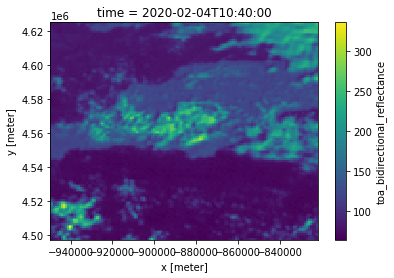

In [57]:
combined_sat_slices[1070].plot()